# Rat 05 forward model with linear elasticity

Required components:
* fenics
* numpy for some array features
* matplotlib not required but useful before opening paraview
* scipy io to bring in matlab matrices
* scipy interpolate to get initial data interpolated onto the mesh from a matrix
* time for reaction-diffusion?
* os for deleting/creating folders and files
* sys for the path to get xdmf parser
* xdmf parser to correct output

In [ ]:
%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import time, os, sys
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from xdmf_parser import xparse as xp

Functions needed for linear elasticity:
* E(u) returns the Green-Lagrange strain tensor
* sigma(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
* vonmises(...) calculates the von Mises stress
* le(...) solves the variational problem for the displacement $u$ given the function spaces, tractions, boundary conditions, tumor cell population, and elasticity coefficients

In [ ]:
def E(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
def sigma(u, phi, mu, lam, beta):
    return 2*mu*(E(u)-beta*phi*Identity(2))+lam*(tr(E(u))-2*beta*phi)*Identity(2)
def vonmises(u, W, phi, mu, lam, beta):
    s = sigma(u, phi, mu, lam, beta) - (1./3)*tr(sigma(u, phi, mu, lam, beta))*Identity(2)  # deviatoric stress
    von_Mises = sqrt(3./2*inner(s, s))
    return project(von_Mises, W)
def le(V, W, T, n, mbc, phi, mu, lam, beta):
    u = TrialFunction(V)
    v = TestFunction(V)
    F = -inner(sigma(u, phi, mu, lam, beta), E(v))*dx + dot(T*n,v)*ds
    a, L = lhs(F), rhs(F)
    u = Function(V)
    solve(a == L, u, mbc)
    return u

Reaction diffusion function:
* Returns the distribution of tumor cells after a time step $dt$ given the function space, current distribution of tumor cells, diffusion coefficient, and growth coefficient

In [ ]:
def rd(dt, V, phi_n, D, alpha):
    phi = Function(V)
    v = TestFunction(V)
    #dt = Constant(dt)
    F = (1./dt)*(phi - phi_n)*v*dx \
        + D*dot(grad(v),grad(phi))*dx \
        - alpha*phi*(1 - phi)*v*dx   
    solve(F == 0, phi)
    return phi

Class to get tumor cell distributions by interpolating based off matrices of tumor cell data

In [ ]:
class InterpolatedParameter(Expression):
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


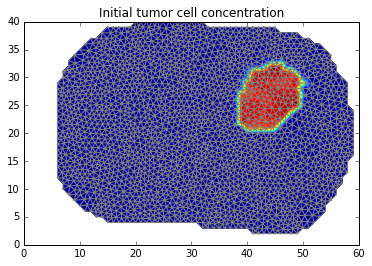

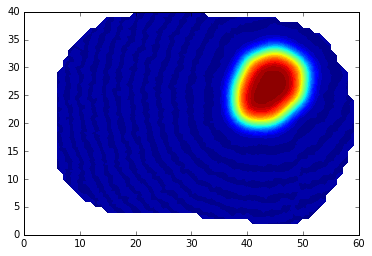

In [66]:
# Create mesh and define function spaces
mesh = Mesh("../rat-data/rat05/gmsh.xml")
cf = MeshFunction("size_t",mesh,"../rat-data/rat05/gmsh_physical_region.xml")
V = VectorFunctionSpace(mesh, 'P', 2)    # Function space for displacement
W = FunctionSpace(mesh, 'P',1)           # Function space for tumor cells

# Load initial tumor condition data
tumor = scio.loadmat("../rat-data/rat05/ic.mat")['ic']
tumor = np.fliplr(tumor.T)/np.max(tumor)               # Needs to be adjusted to fit the mesh correctly
x,y = tumor.shape[0], tumor.shape[1]
phi_0 = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),tumor,degree=1)
phi_n = project(phi_0,W)                 # use the fenics project function to apply the interpolation to the DOFs

# Display initial conditions on mesh
plt.figure()
plot(mesh)
plot(phi_n,title="Initial tumor cell concentration")

# Variables
T = 1.                    # final time
num_steps = 100           # number of time steps
dt = T / num_steps        # time step size
Dt = 1.                 # Diffusion coefficient
alphat = 1.              # Reaction coeffecient
gamma1, gamma2 = .01,.01 # stress-to-diffusion/reaction coefficient
mu, lam = 1.0, 1.0        # lame parameters
nu = lam/(2*(lam+mu))     # Poisson's ratio
beta = 1                  # tumor coefficient

# Define expressions and functions used in variational forms
D = project(Constant(Dt),W)              # Diffusion constant throughout
alpha = project(Constant(alphat),W)      # Reaction constant throughout

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

T = Expression((('0','0'),('0','0')),degree=1)
n = FacetNormal(mesh)

# Save output
os.system('rm ./output/rat05/*')
phifile = XDMFFile('./output/rat05/solution.xdmf')
u, vm, phi = Function(V), Function(W), Function(W)
#u.rename("disp","")
#vm.rename("vonmises","")
#phi.rename("phi","")

t = 0.0
for i in range(num_steps):
    t += dt
    u = le(V, W, T, n, bc, phi_n, mu, lam, beta)
    vm = vonmises(u, W, phi_n, mu, lam, beta)
    D = Dt*exp(-gamma1*vm)
    alpha = alphat*exp(-gamma2*vm)
    phi = rd(dt, W, phi_n, D, alpha)
    
    # Update previous solution
    phi_n.assign(phi)
    
    # Save solution to file (xdmf)
#    phifile.write(u,t)
#    phifile.write(vm,t)
    phifile.write(project(D,W),t)
    
del phifile
plt.figure()
plot(phi_n)
#xp("output/rat05/solution.xdmf")


In [65]:
test = project(exp(-gamma1*vm),W)
np.min(test.compute_vertex_values())

-0.027074045448804245